In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import os
import math

### to change according to your machine
base_dir = os.path.expanduser("/home/data/lcz")
path_training = os.path.join(base_dir, 'training.h5')
path_validation = os.path.join(base_dir, 'validation.h5')

fid_training = h5py.File(path_training,'r')
fid_validation = h5py.File(path_validation,'r')

## we can have a look at which keys are stored in the file
## you will get the return [u'label', u'sen1', u'sen2']
## sen1 and sen2 means the satellite images
#print fid_training.keys()
print (fid_validation.keys())

### get s1 image channel data
### it is not really loaded into memory. only the indexes have been loaded.
print ("-" * 60)
print ("training part")
s1_training = fid_training['sen1']
print (s1_training.shape)
s2_training = fid_training['sen2']
print (s2_training.shape)
label_training = fid_training['label']
print (label_training.shape)

print ("-" * 60)
print ("validation part")
s1_validation = fid_validation['sen1']
print (s1_validation.shape)
s2_validation = fid_validation['sen2']
print (s2_validation.shape)
label_validation = fid_validation['label']
print (label_validation.shape)

KeysView(<HDF5 file "validation.h5" (mode r)>)
------------------------------------------------------------
training part
(352366, 32, 32, 8)
(352366, 32, 32, 10)
(352366, 17)
------------------------------------------------------------
validation part
(24119, 32, 32, 8)
(24119, 32, 32, 10)
(24119, 17)


In [2]:
'''s1 = s1_validation[:200,...]
s2 = s2_validation[:200,...]
del s1_training, s2_training
x_training = np.concatenate((s1,s2),axis=3)

print(x_training.shape)'''

s1=[]
s2=[]
for i in range(17):
    idx=np.where(label_validation[:,i])[0][:200]
    s1.append(s1_validation[list(idx)])
    s2.append(s2_validation[list(idx)])
s1=np.concatenate(s1)
s2=np.concatenate(s2)

In [3]:
# lee filter  非常耗时 暂时不做
'''
for i in range(s1.shape[0]):
    for j in range(8):
        #s1[i,:,:,j] = lee_filter(s1[i,:,:,j],win_size=5,cu=0.5)
        s1[i,:,:,j] = median_filter(s1[i,:,:,j],win_size=3) '''


# s1 processing
for i in range(0,4,2):
    locals()['s1_'+str(i)] =  np.sqrt(np.square(s1[:,:,:,i])+np.square(s1[:,:,:,i+1]))
    #振幅值取log
    locals()['s1_'+str(i)] = np.log10(locals()['s1_'+str(i)]+0.0000001)
    locals()['s1_'+str(i+1)] =  np.arctan2(s1[:,:,:,i+1],s1[:,:,:,i])
s1_4 = np.log10(s1[:,:,:,4]+0.0000001)
s1_5 = np.log10(s1[:,:,:,5]+0.0000001)
s1_6 = np.sqrt(np.square(s1[:,:,:,6])+np.square(s1[:,:,:,7]))
s1_6 = np.log10(s1_6+0.0000001)
s1_7 = np.arctan2(s1[:,:,:,7],s1[:,:,:,6])

s1_energy = np.zeros(s1.shape)
for i in range(8):
    s1_energy[:,:,:,i] = locals()['s1_'+str(i)]

for i in range(s1.shape[0]):
    for j in range(8):
        if j % 2 == 0:
            #幅度归一化
            s1_energy[i,:,:,j] -= np.mean(s1_energy[i,:,:,j],axis=0)
            s1_energy[i,:,:,j] /= np.std(s1_energy[i,:,:,j],axis=0)+0.0000001
            s1_energy[i,:,:,j] = (s1_energy[i,:,:,j] - s1_energy[i,:,:,j].min()) / (s1_energy[i,:,:,j].max() - s1_energy[i,:,:,j].min())
        else:
            #相位归一化
            if j == 5:  #单独处理
                s1_energy[i,:,:,j] -= np.mean(s1_energy[i,:,:,j],axis=0)
                s1_energy[i,:,:,j] /= np.std(s1_energy[i,:,:,j],axis=0)+0.0000001
                s1_energy[i,:,:,j] = (s1_energy[i,:,:,j] - s1_energy[i,:,:,j].min()) / (s1_energy[i,:,:,j].max() - s1_energy[i,:,:,j].min())
                continue
            s1_energy[i,:,:,j] = (s1_energy[i,:,:,j] + np.pi) / (2*np.pi)
print(s1_energy[i,:,:,0].mean(),s1_energy[i,:,:,0].std(), s1_energy[i,:,:,0].max(), s1_energy[i,:,:,0].min())

# s2 processing
#取log, 归一化
for i in range(s2.shape[0]):
    for j in range(10):
        s2[i,:,:,j] = np.log10(s2[i,:,:,j]+0.0000001)
        s2[i,:,:,j] -= np.mean(s2[i,:,:,j],axis=0)
        s2[i,:,:,j] /= np.std(s2[i,:,:,j],axis=0)+0.0000001
        s2[i,:,:,j] = (s2[i,:,:,j] - s2[i,:,:,j].min()) / (s2[i,:,:,j].max() - s2[i,:,:,j].min())
print(s2[i,:,:,0].mean(),s2[i,:,:,0].std(),s2[i,:,:,0].max(),s2[i,:,:,0].min())


0.7087028423451747 0.13292940939378478 1.0 0.0
0.557104241153941 0.18153711301785577 1.0 0.0


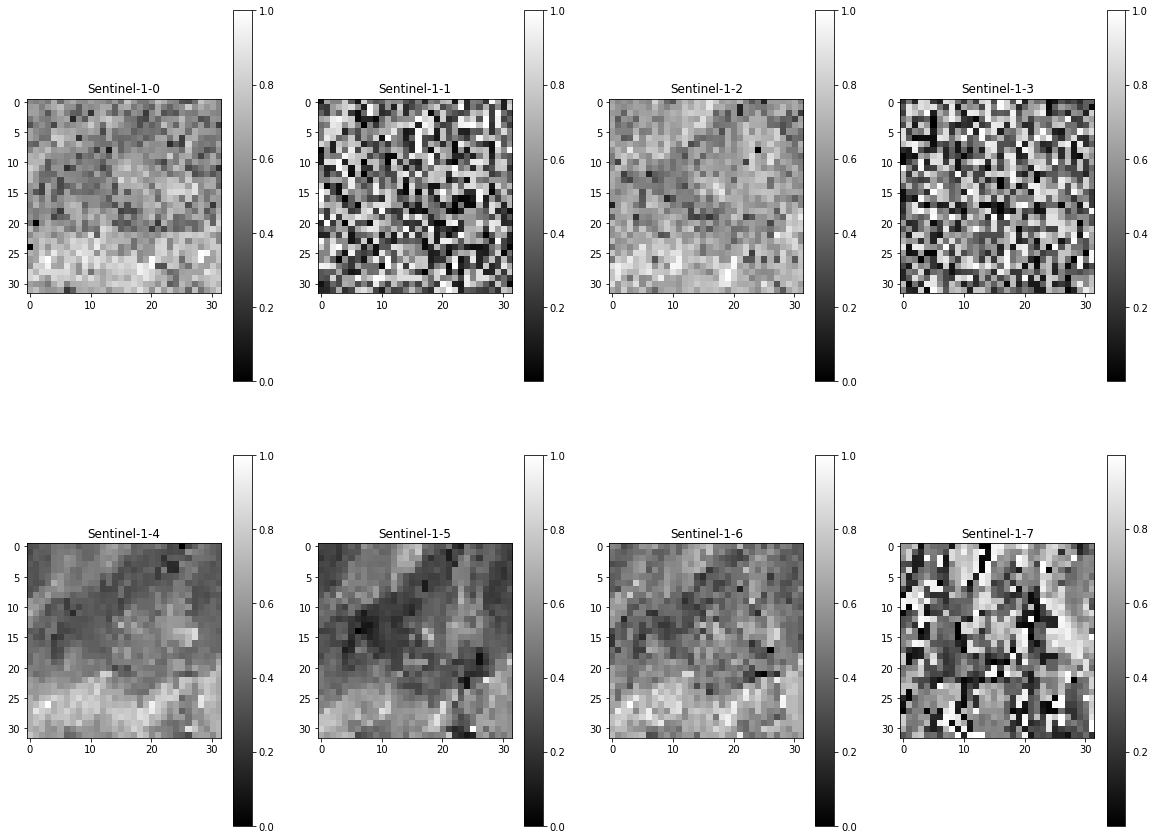

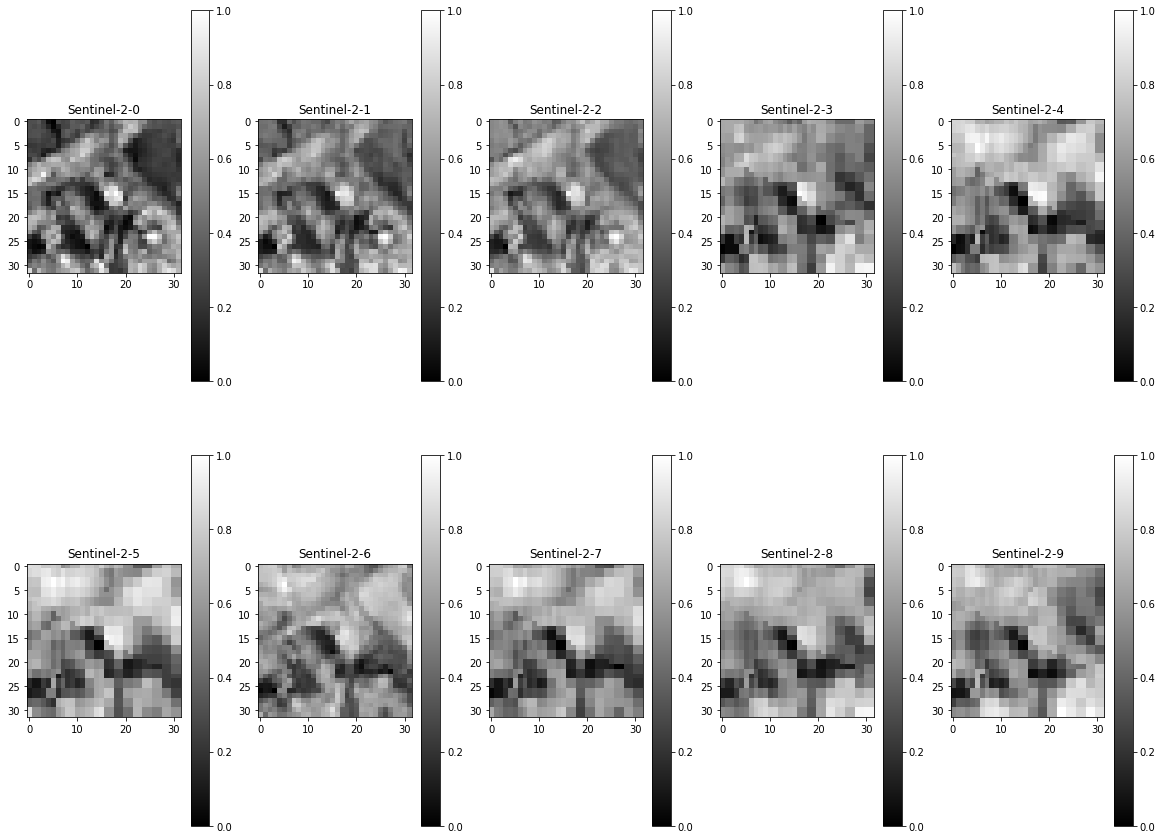

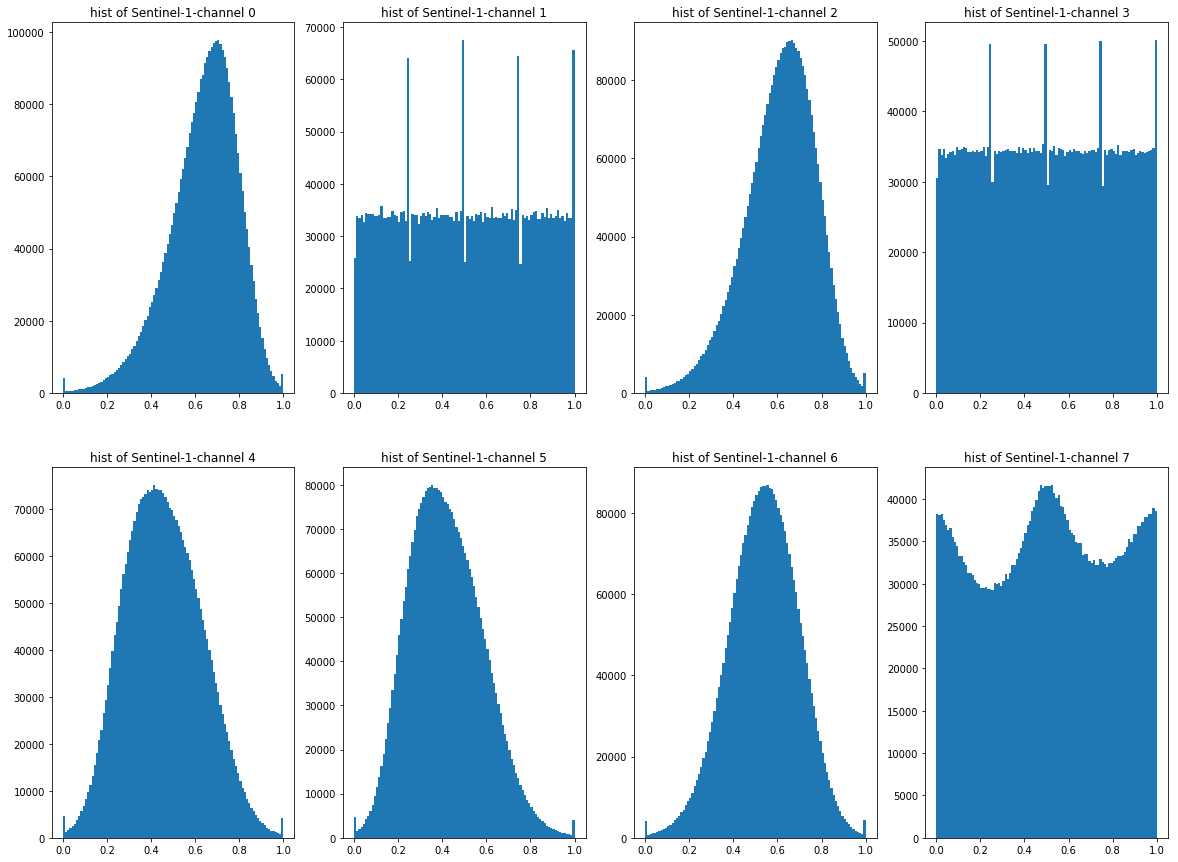

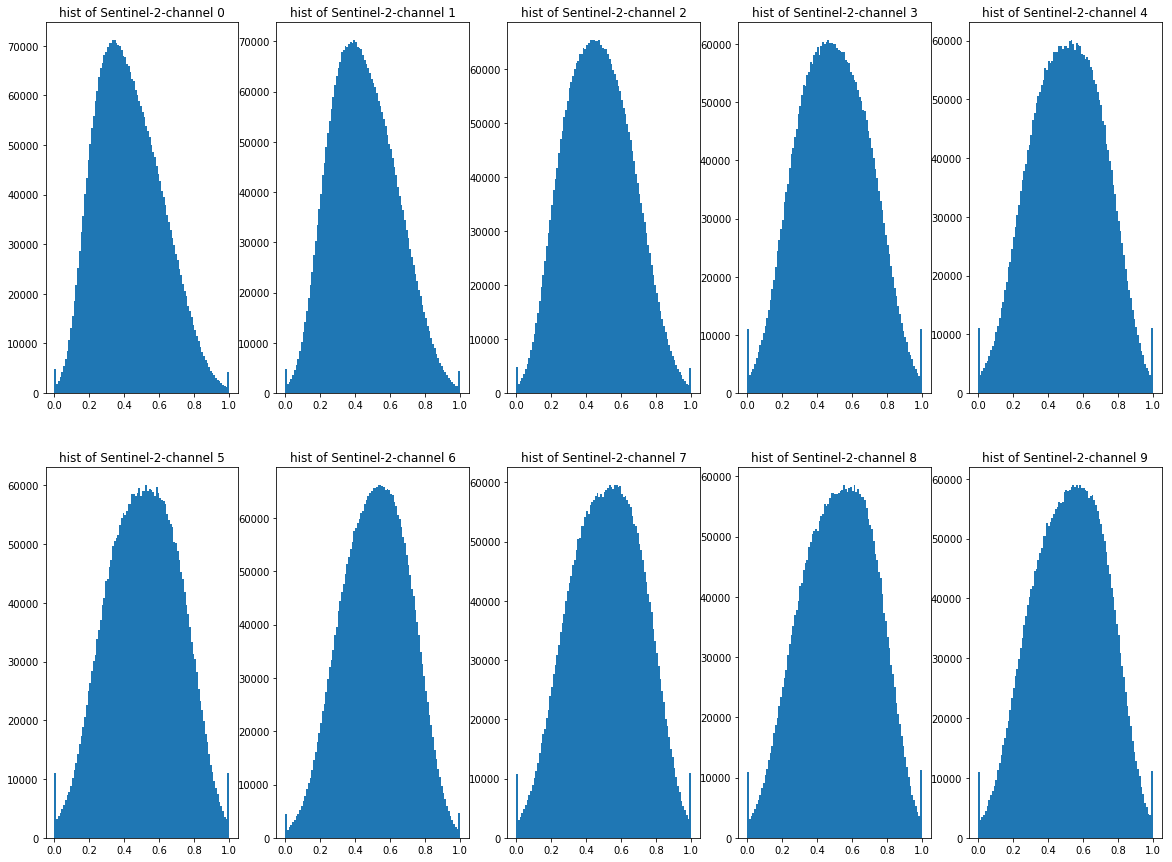

In [4]:
#s1
plt.subplots(figsize=(20, 15))
for i in range(8):
  plt.subplot(2,4,i+1)
  plt.imshow(s1_energy[0,:,:,i],cmap=plt.cm.get_cmap('gray'));
  plt.colorbar()
  plt.title('Sentinel-1-%d'%(i))
plt.show()
#s2
plt.subplots(figsize=(20, 15))
for i in range(10):
  plt.subplot(2,5,i+1)
  plt.imshow(s2[0,:,:,i],cmap=plt.cm.get_cmap('gray'));
  plt.colorbar()
  plt.title('Sentinel-2-%d'%(i))
plt.show()
#hist
plt.subplots(figsize=(20,15))
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.hist(s1_energy[:,:,:,i].reshape([-1]),bins=100);plt.title('hist of Sentinel-1-channel '+str(i))
plt.show()
plt.subplots(figsize=(20,15))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.hist(s2[:,:,:,i].reshape([-1]),bins=100);plt.title('hist of Sentinel-2-channel '+str(i))
plt.show()

In [4]:
f = h5py.File('training_preprc.h5','w')
f.create_dataset('s1',data=s1_energy)
f.create_dataset('s2',data=s2)
f.close()